# TUnfoldDensity example with pyroot

In [1]:
import ROOT
import numpy as np
import array as array
import math
ROOT.gStyle.SetOptStat(000000)

Welcome to JupyROOT 6.10/04


## Construct the Binning scheme

Set the axis ranges for the generator (m bins) and detector  (n bins) level distributions as well as the number of bins in each. *Note* that we are currently using twice as many detector bins as generator level bins as recommended by the TUnfold documenation. This condition $n ≥ m$ 
is in contrast to many common unfoldding algorithms which require $n = m$ however a notable example of an unfolding algorithm without that restriction is __[G. D’Agostini](arXiv:1010.0632)__.

In [2]:
### Set up the binning scheme
mbinsGen  = array.array('d', [0., 20., 100. ])
mbinsDet  = array.array('d', [0., 10.,20.,60.,100. ])
ptbinsGen = array.array('d', [0., 50., 100. ])
ptbinsDet = array.array('d', [0., 50., 100. ])

nmbinsGen  = len(mbinsGen) -1
nmbinsDet  = len(mbinsDet) -1
nptbinsGen = len(ptbinsGen) -1
nptbinsDet = len(ptbinsDet) -1

print "There are {} Gen Mass bins , {} Gen Pt bins ,{} Reco Mass bins , {} Reco Pt bins  ".format(nmbinsGen,nptbinsGen , nmbinsDet,nptbinsDet)

There are 2 Gen Mass bins , 2 Gen Pt bins ,4 Reco Mass bins , 2 Reco Pt bins  


Instantiate the TUnfoldBinning Scheme. The "signal" node represents the generator level (coarser) binning whereas the "detector" node represents the (finer) input binning scheme. 

In [3]:
generatorBinning = ROOT.TUnfoldBinning("generator")
### Need coarser binning for signal
signalBinning = generatorBinning.AddBinning("signal")    
signalBinning.AddAxis("massgen",nmbinsGen,mbinsGen,
                        True, # needed for fakes
                        True # overflow bin
                        )
signalBinning.AddAxis("ptgen",nptbinsGen,ptbinsGen,
                        True, # needed for fakes
                        True # overflow bin
                        )

# X axis : generator binning is Signal : mgen * ptgen and Background : mrec * ptrec

xaxis =  array.array('d',[a for a in xrange(nmbinsGen *nptbinsGen + 1 )])
nx = len(xaxis)-1

print xaxis
print "There are {} (signal) generator level bins in the simple scheme".format(nx)
print "---------------------------------------------------------------"

print "signalBinning"
for i in xrange(len(signalBinning.GetDistributionBinning(0))):
    print  signalBinning.GetDistributionBinning(0)[i]

#print "detectorBinning"
#for i in xrange(len(backgroundBinning.GetDistributionBinning(0))):
#    print backgroundBinning.GetDistributionBinning(0)[i]
    
#print "Below counts include overflow and underflow bins"    
#print "There are {} signal {} background bins in the generator scheme".format(signalBinning.GetTH1xNumberOfBins() , backgroundBinning.GetDistributionNumberOfBins())


array('d', [0.0, 1.0, 2.0, 3.0, 4.0])
There are 4 (signal) generator level bins in the simple scheme
---------------------------------------------------------------
signalBinning
0.0
50.0
100.0


In [4]:
detectorBinning = ROOT.TUnfoldBinning("detector") 
detectorDistribution=detectorBinning.AddBinning("detectordistribution")
detectorDistribution.AddAxis("mass",nmbinsDet,mbinsDet,
                        False, # no underflow bin (not reconstructed)
                        True # overflow bin
                        )
detectorDistribution.AddAxis("pt",nptbinsDet,ptbinsDet,
                        False, # no underflow bin (not reconstructed)
                        True # overflow bin
                        )

yaxis =  array.array('d',[a for a in xrange(nmbinsDet *nptbinsDet+1 )])
ny = len(yaxis)-1

print yaxis
print "There are {}  detector level bins in the simple scheme".format(ny)
print "detectorBinning"
for i in xrange(len(detectorDistribution.GetDistributionBinning(0))):
    print detectorDistribution.GetDistributionBinning(0)[i]
    
print "Below counts include overflow and underflow bins"  
print "There are {} bins in the detector scheme".format(detectorDistribution.GetTH1xNumberOfBins())#GetDistributionNumberOfBins())


array('d', [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
There are 8  detector level bins in the simple scheme
detectorBinning
0.0
25.0
50.0
75.0
100.0
Below counts include overflow and underflow bins
There are 15 bins in the detector scheme


# Create Response Matrix and 1D input 

In [5]:


M = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M")
M1 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M+1#sigma")
M2 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M-1#sigma")

h = detectorBinning.CreateHistogram("h")

hup = detectorBinning.CreateHistogram("hup")
hdn = detectorBinning.CreateHistogram("hdn")


htrue = generatorBinning.CreateHistogram("htrue")
htruef = detectorBinning.CreateHistogram("htruef")



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: creating converter for unknown type "int**"
  import sys


## Generate the response matrix

Here, we have a respone matrix with 4 coarse and 8 fine bins (configurable). The variable of interest ($x$) ranges from 0 to 100. We assume the resolution on $x$ is 1.0, and that there is a systematic uncertainty "scale", which has an "up" and "down" variation of 2%. We generate 10000 pseudo-events for each value of x between 0 and 100, smeared by the resolution. For each of the "x" values, a reconstructed "y" value is constructed, again smeared by the resolution. We then add the "up" and "down" scale uncertainites. Finally, we construct TH2 matrices that represent the response matrices. 

In [6]:

res = 1.0

Npe = 100#10000 #10000
minval = 0
maxval = 100


v = np.linspace(minval, maxval, maxval+1)

# First get a Gaussian centered at each bin with the experimental resolution
## reco x and y measurements
rx = [ np.random.normal(loc=x,scale=res,size=Npe) for x in v ]
ry = [ np.random.normal(loc=x,scale=res,size=Npe) for x in rx ]

## gen x and y measurements
gx = [ np.random.normal(loc=x,scale=5.0,size=Npe) for x in rx ]
gy = [ np.random.normal(loc=x,scale=5.0,size=Npe) for x in ry ]
print "done"
#print gx

done


In [7]:
scaleup = 1.02
scaledn = 0.98

# Next scale the reco up and down
ry_up = [ y*scaleup for y in ry ]
ry_dn = [ y*scaledn for y in ry ]



In [8]:

#rx = [ np.random.normal(loc=x,scale=res,size=Npe) for x in v ]
#ry = [ np.random.normal(loc=x,scale=res,size=Npe) for x in rx ]
###
#txvals = np.random.normal(loc=(maxval-minval)/2,scale=30,size=1000)#1000000)
#xvals = [ np.random.normal(loc=t,scale=res) for t in txvals]

#print txvals[:10]
#print xvals[:10]
#yvals = [ x * np.random.normal(loc=1,scale=0.1) for x in xvals ]
#tyvals = np.random.normal(loc=(maxval-minval)/2,scale=30,size=1000 ) #1000000)


hup.SetLineStyle(2)
hdn.SetLineStyle(3)


for i in xrange(len(rx)):    
    for j in xrange(len(ry[i])):
        xr = rx[i][j]
        yr = ry[i][j]

        xg = gx[i][j]
        yg = gy[i][j]
        
        #print x 
        #print y
        
        gxb=signalBinning.GetGlobalBinNumber(xg, yg)
        gyb= detectorDistribution.GetGlobalBinNumber(xr,yr)
        h.Fill(gyb)
        gyu = detectorDistribution.GetGlobalBinNumber(xr * scaleup, yr* scaleup)
        gyd = detectorDistribution.GetGlobalBinNumber(xr * scaledn, yr* scaledn)
        hup.Fill(gyu)
        hdn.Fill(gyd)        
        #print gx
        #print gy
        #gxn = signalBinning.GetBinName(gxb)
        #gyn = detectorDistribution.GetBinName(gyb)
        #print gxn
        #print gyn        
        yru= ry_up[i][j]
        yrd= ry_dn[i][j]
        
        gyub = detectorDistribution.GetGlobalBinNumber(xr,yru)
        gydb = detectorDistribution.GetGlobalBinNumber(xr,yrd)
        
        #print ' %10.7f %10.7f + %10.7f - %10.7f ' % ( x, y, yu, yd )
        M.Fill(gxb, gyb)#, #1./Npe)
        M1.Fill(gxb, gyub)#, 1./Npe)
        M2.Fill(gxb, gydb)#, 1./Npe)

 
        htrue.Fill(gxb)
        rgyb= detectorDistribution.GetGlobalBinNumber(xg,yg)

        htruef.Fill(rgyb)


## Draw the response matrix

We draw the nominal and $\pm 1 \sigma$ variations. 

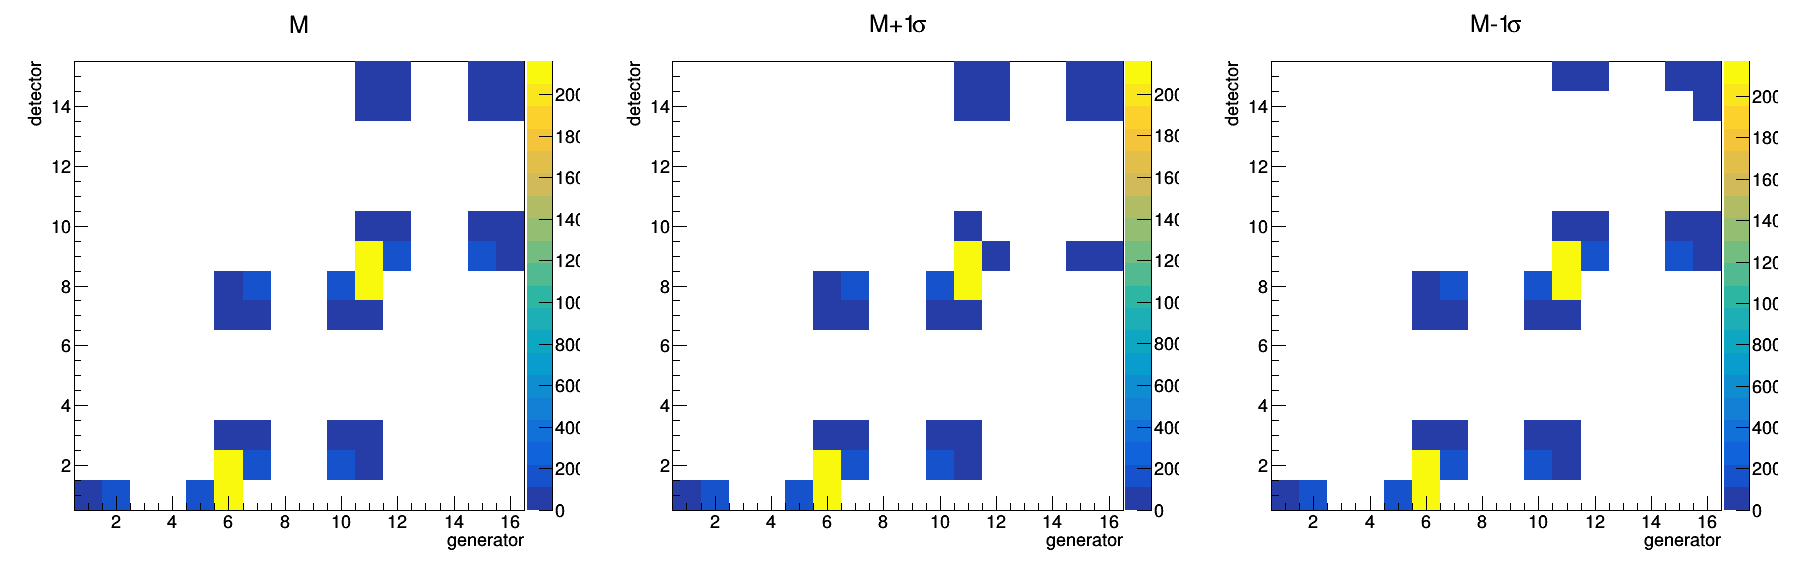

In [9]:

c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
M.Draw("colz")
c0.cd(2)
M1.Draw("colz")
c0.cd(3)
M2.Draw("colz")
c0.Draw()

In [10]:
for bx in xrange(M.GetNbinsX()):
    for by in xrange(M.GetNbinsY()):
        bc = M.GetBinContent(bx,by)
        if bc > 1. :
            gxn = signalBinning.GetBinName(bx)
            gyn = detectorDistribution.GetBinName(by)
            print "Bin X {} {} Y {} {} is filled with {} ".format(bx, gxn, by, gyn, bc)

Bin X 1 #1 (signal:ptgen[ufl]:massgen[ufl]) Y 0 #0 is filled with 34.0 
Bin X 1 #1 (signal:ptgen[ufl]:massgen[ufl]) Y 1 #1 (detectordistribution:pt[0,50]:mass[0,25]) is filled with 50.0 
Bin X 2 #2 (signal:ptgen[ufl]:massgen[0,50]) Y 0 #0 is filled with 28.0 
Bin X 2 #2 (signal:ptgen[ufl]:massgen[0,50]) Y 1 #1 (detectordistribution:pt[0,50]:mass[0,25]) is filled with 123.0 
Bin X 5 #5 (signal:ptgen[0,50]:massgen[ufl]) Y 0 #0 is filled with 19.0 
Bin X 5 #5 (signal:ptgen[0,50]:massgen[ufl]) Y 1 #1 (detectordistribution:pt[0,50]:mass[0,25]) is filled with 136.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 0 #0 is filled with 24.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 1 #1 (detectordistribution:pt[0,50]:mass[0,25]) is filled with 2134.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 2 #2 (detectordistribution:pt[0,50]:mass[25,50]) is filled with 2159.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 3 #3 (detectordistribution:pt[0,50]:mass[50,75]) is filled with 9.0 
Bin

## Plot the reconstructed and truth

In [11]:
crec1 = ROOT.TCanvas("cr1", "creco", 600, 600)


In [12]:
h2 = M.ProjectionY("reco2")

In [13]:
htruef.SetLineColor(2)
h.SetMarkerStyle(20)
h2.SetMarkerStyle(22)

htruef.SetMarkerStyle(21)

h.SetMarkerColor(ROOT.kBlue)
h2.SetMarkerColor(ROOT.kMagenta)
htruef.SetMarkerColor(ROOT.kRed)
h.SetLineColor(ROOT.kBlue)
htruef.SetLineColor(ROOT.kRed)


In [14]:

h.Draw('e')
h2.Draw('e same')

hup.Draw("hist same")
hdn.Draw("hist same")
htruef.Draw("e same")


In [15]:
leg1 = ROOT.TLegend(0.7,0.7,0.86, 0.86)
leg1.SetBorderSize(0)
leg1.SetFillColor(0)
leg1.AddEntry( h2, 'Reco from M', 'p')
leg1.AddEntry( h, 'Reco', 'p')
leg1.AddEntry( hup, '+1#sigma', 'l')
leg1.AddEntry( hdn, '-1#sigma', 'l')
leg1.AddEntry( htruef, 'True', 'p')
leg1.Draw()

In [16]:
#crec1.Draw()

## Unfold

1. Create the `TUnfoldDensity` object. 
1. Add the systematic uncertainty variations via `AddSysError`. 
1. Perform the regularization by scanning the L curve. 
1. Get the output. **Note! This does not account for systematic uncertainties automatically. They must be added by hand.**
1. Draw unfolded versus true distributions (in the same coarse binning scheme). 

In [17]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintNone#Area #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

u = ROOT.TUnfoldDensity(M,orientation,regMode,con)


Info in <TUnfold::SetConstraint>: fConstraint=0
Warning in <TUnfold::TUnfold>: 8 output bins do not depend on the input data  0 3-4 8-9 13-14 17
Info in <TUnfold::TUnfold>: 15 input bins and 10 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:generator[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (xaxis:generator[2.5,3.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:generator[3.5,4.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #8 (xaxis:generator[7.5,8.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (xaxis:generator[8.5,9.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:generator[12.5,13.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #14 (xaxis:generator[13.5,14.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #17 (xaxis:generator[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=3 axisSteering=*[UOB]

In [18]:
u.SetInput( h )


6

Warning in <TUnfoldDensity::SetInput>: 6/15 input bins have zero error, and are ignored.


In [19]:
u.AddSysError(M1, "Up", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
u.AddSysError(M2, "Dn", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
#ROOT.TUnfoldDensity.kSysErrModeRelative)# ROOT.TUnfoldDensity.kSysErrModeShift)


In [20]:
# Regularize
nScan=50
tauMin=0.0
tauMax=0.0
iBest=0

logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
lCurve = ROOT.MakeNullPointer(ROOT.TGraph)
u.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)


3

Error in <TUnfoldDensity::GetInputInverseEmatrix>: number of parameters 10 > 9 (rank of input covariance). Problem can not be solved
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of matrix E 8 expect 10
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 8 expect 10
Error in <TUnfoldDensity::ScanLcurve>: too few input bins, NDF<=0 -1
Info in <TUnfoldDensity::ScanLcurve>: logtau=-Infinity X=-24.889519 Y=7.543089
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of matrix E 8 expect 10
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 8 expect 10
Info in <TU

In [21]:
# Get output... DOES NOT CONTAIN SYSTEMATICS. 
o = u.GetOutput("o")


In [22]:
# Get systematic shifts of output
o_up = u.GetDeltaSysSource("Up", "o_upshift", "M+1#sigma")
o_dn = u.GetDeltaSysSource("Dn", "o_dnshift", "M-1#sigma")
o_up.SetLineStyle(2)
o_dn.SetLineStyle(2)


In [23]:
# Get various covariances
cov = u.GetEmatrixTotal("cov", "Covariance Matrix")
cov_uncorr = u.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
cov_uncorr_data = u.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")


In [24]:

# Now prepare various distributions. 
o_unfunc = o.Clone("o_unc")        # Unfolding and stat unc
o_sys = o.Clone("o_sys")        # Syst uncertainty
o_unctot = o.Clone("o_unctot")  # Total uncertainty
o_sys.SetLineStyle(2)


In [25]:

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output
for i in xrange( 0, o_up.GetNbinsX() + 1):
    unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(i,i) )
    o_unctot.SetBinContent(i, unc_tot )    
    o.SetBinError(i, unc_tot )
    
    yup = abs( o_up.GetBinContent(i))
    ydn = abs( o_dn.GetBinContent(i))
    dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
    o_sys.SetBinContent(i, dy )






In [26]:
#htrue2 = htrue.Clone("h2")
#htrue2.Rebin(finebins/coarsebins)
o.SetMarkerStyle(20)
o.SetMarkerColor(1)
o_unfunc.SetMarkerStyle(0)
o_unfunc.SetLineColor(2)
htrue.SetMarkerStyle(21)
htrue.SetMarkerColor(4)
htrue.SetMarkerStyle(4)
htrue.SetLineColor(4)



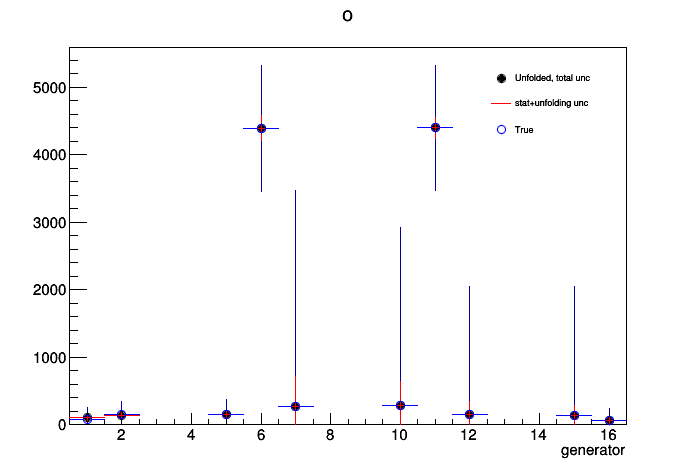

In [27]:
c = ROOT.TCanvas("c","c")
o.SetMinimum(0.0)
o.Draw()
o_unfunc.Draw("e same")
htrue.Draw("e same")
leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry( o, "Unfolded, total unc",'p')
leg2.AddEntry( o_unfunc, "stat+unfolding unc",'l')
leg2.AddEntry( htrue, "True",'p')
leg2.Draw()
c.Draw()

## Draw the LCurve. 

<ROOT.TGraph object ("Graph") at 0x7fac4a52abc0>


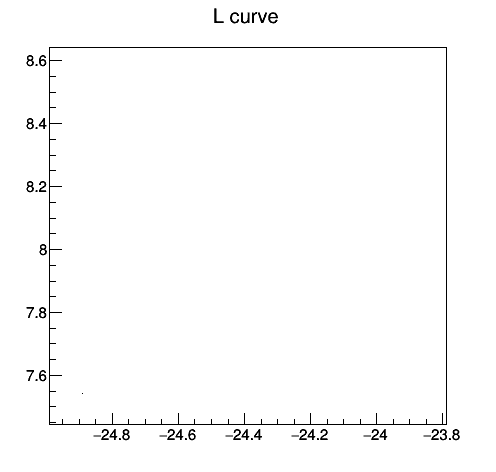

In [28]:
print lCurve
if lCurve:
    cl = ROOT.TCanvas("cl", "cl", 500, 500)
    lCurve.Draw("alp")
    cl.Draw()

## Plot closure

The closure plot is the true distribution divided by the unfolded distribution. Aside from the outermost bins, the closure is consistent with unity. 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


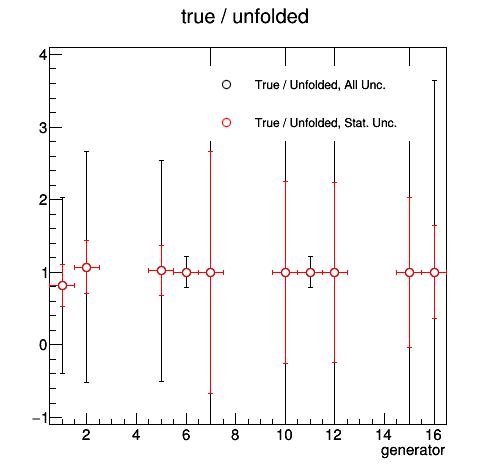

In [35]:
c2 = ROOT.TCanvas("c2", "c2", 500, 500)
closure = htrue.Clone("closure")
closure2 = htrue.Clone("closure2")
closure.SetMarkerColor(1)
closure.SetLineColor(1)
closure2.SetMarkerColor(2)
closure2.SetLineColor(2)
closure.SetTitle("true / unfolded")
closure.Divide(o)
closure2.Divide(o_unfunc)
closure.Draw('e1')
closure2.Draw('e1 same')
closure.SetMaximum(4.1)
closure.SetMinimum(-1.1)

legclosure = ROOT.TLegend(0.4, 0.7, 0.86, 0.86)
legclosure.SetBorderSize(0)
legclosure.SetFillColor(0)
legclosure.AddEntry( closure, "True / Unfolded, All Unc.", 'p')
legclosure.AddEntry( closure2, "True / Unfolded, Stat. Unc.", 'p')
legclosure.Draw()
c2.Draw()

## Plot the total covariance matrix

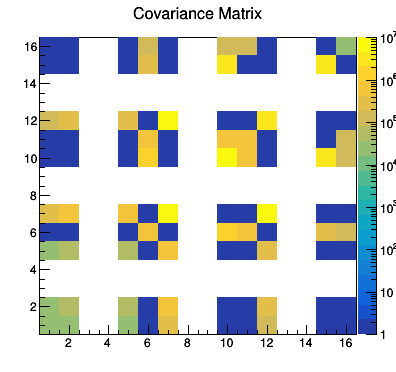

In [30]:

ccov = ROOT.TCanvas("ccov", "Covariance Matrix", 400, 400)
cov.Draw('colz')
ccov.SetLogz()
ccov.Draw()


## Plot the covariance matrix from uncorrelated (stat.) uncertainties

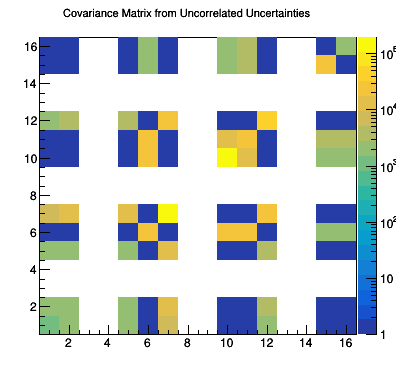

In [31]:

ccov_uncorr = ROOT.TCanvas("ccov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr.Draw('colz')
ccov_uncorr.SetLogz()
ccov_uncorr.Draw()



## Plot covariance matrix of the statistical uncertainties from the input data

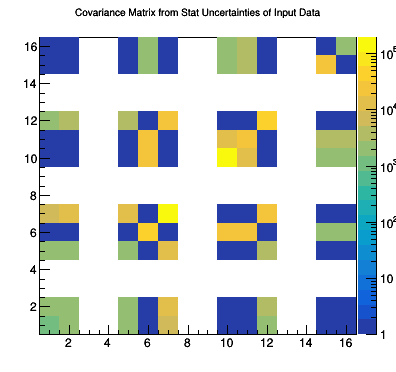

In [32]:

ccov_uncorr_data = ROOT.TCanvas("ccov_uncorr_data", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr_data.Draw('colz')
ccov_uncorr_data.SetLogz()
ccov_uncorr_data.Draw()



## Plot absolute uncertainties



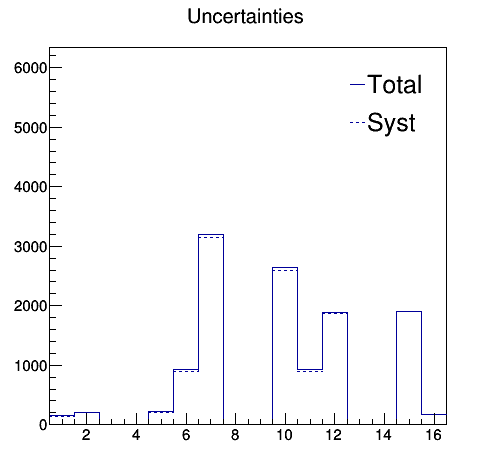

In [33]:

#
unc_stack = ROOT.THStack("unc_stack", "Uncertainties")
unc_stack.Add( o_unctot, "hist" )
unc_stack.Add( o_sys, "hist" )
#o_up.Divide(o)
#o_dn.Divide(o)



c_sys = ROOT.TCanvas("c_sys", "c_sys", 500, 500)
unc_stack.Draw("nostack")
unc_stack.SetMaximum( 1.0 * unc_stack.GetMaximum() )
#o_unc.SetMinimum(-0.2)
#o_unc.SetMaximum(+0.2)
legsys = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
legsys.SetFillColor(0)
legsys.SetBorderSize(0)
legsys.AddEntry( o_unctot, 'Total', 'l')
legsys.AddEntry( o_sys, 'Syst', 'l')
legsys.Draw()
c_sys.Draw()